# Importation des librairies/datasets

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# K-medoïde
!pip install pyclustering
from pyclustering.cluster.kmedoids import kmedoids

# Partition binaire
from sklearn.cluster import AgglomerativeClustering

# PCoA
from sklearn.decomposition import KernelPCA

# Isomap
from sklearn.manifold import Isomap

# K-plus proches voisins
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import accuracy_score

In [2]:
#Importe les données MNIST
from keras.datasets import mnist
(mnist_train_data, mnist_train_labels), (mnist_test_data, mnist_test_labels) = mnist.load_data()
mnist_train_data = mnist_train_data.reshape((mnist_train_data.shape[0],28*28)) / 255
mnist_test_data  = mnist_test_data.reshape((mnist_test_data.shape[0],28*28)) / 255

11490434/11490434 [==============================] - 0s 0us/step


# MNIST

In [39]:
class cosine_sim:
  def sim(self, x, y, *args, **kwargs):
    return (x*y).sum(*args, **kwargs)/np.sqrt((x*x).sum(*args, **kwargs) * (y*y).sum(*args, **kwargs))

  def dissim(self, x, y, *args, **kwargs):
    return 1 - self.sim(x, y, *args, **kwargs)

  def dissim_mat(self, X, Y=None):
    Y = X if Y is None else Y
    return self.dissim(X[:,None], Y[None,:], axis=2)

In [4]:
class euclidian_dist:
  def dissim(self, x, y, *args, **kwargs):
    return np.sqrt(((x - y) ** 2).sum(*args, **kwargs))

  def dissim_mat(self, X, Y=None):
    Y = X if Y is None else Y
    return self.dissim(X[:,None], Y[None,:], axis=2)

In [40]:
dist = cosine_sim()

## Test

In [6]:
mnist_train_mean_data = mnist_train_data[:30000]
mnist_train_dist_data = mnist_train_data[30000:]
mnist_train_mean_labels = mnist_train_labels[:30000]
mnist_train_dist_labels = mnist_train_labels[30000:]

In [7]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z),axis=0)

In [8]:
probabilites = np.zeros((10, mnist_train_mean_data.shape[1]))

for i in range(mnist_train_mean_data.shape[0]):
  probabilites[mnist_train_mean_labels[i]] += mnist_train_mean_data[i]

probabilites = np.divide(probabilites.T, np.max(probabilites, axis=1)).T

probabilites = softmax(probabilites)

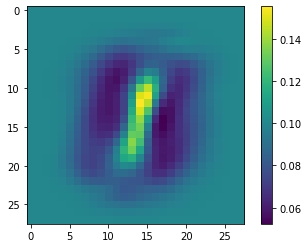

In [9]:
plt.imshow(np.reshape(probabilites[1], (28,28)))
plt.colorbar()
plt.show()

In [10]:
mnist_test_data_sample = np.copy(mnist_test_data[:20])
mnist_test_labels_sample = mnist_test_labels[:20]

In [11]:
mnist_test_data_sample[mnist_test_data_sample > 0] = 1
mnist_test_data_sample[mnist_test_data_sample == 0] = 0

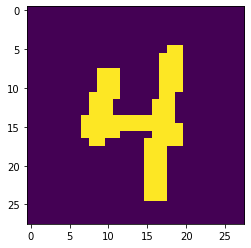

In [12]:
plt.imshow(np.reshape(mnist_test_data_sample[19], (28,28)))

In [13]:
def sim(A,B):
  return np.dot(A, B)

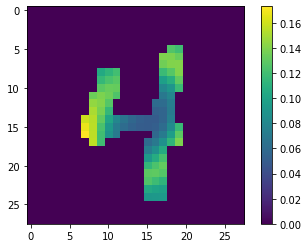

In [14]:
plt.imshow(np.reshape(probabilites[0] * mnist_test_data_sample[19], (28,28)))
plt.colorbar()

In [15]:
test_data = np.zeros((mnist_test_data_sample.shape[0],10))

for i in range(mnist_test_data_sample.shape[0]):
  for j in range(10):
    test_data[i][j] = sim(mnist_test_data_sample[i], probabilites[j])

## Prétraitement

In [16]:
threshold = 0.5

In [17]:
mnist_train_mean_data = mnist_train_data[:30000]
mnist_train_dist_data = mnist_train_data[30000:]
mnist_train_mean_labels = mnist_train_labels[:30000]
mnist_train_dist_labels = mnist_train_labels[30000:]

In [36]:
moyenne = np.zeros((10, mnist_train_mean_data.shape[1]))

for i in range(mnist_train_mean_data.shape[0]):
  moyenne[mnist_train_mean_labels[i]] += mnist_train_mean_data[i]

moyenne = np.divide(moyenne, np.max(moyenne))
moyenne[moyenne > threshold] = 1
moyenne[moyenne <= threshold] = -1

In [37]:
mnist_train_dist_data[mnist_train_dist_data > threshold] = 1
mnist_train_dist_data[mnist_train_dist_data <= threshold] = -1

In [41]:
train_data = np.zeros((10, 10))

for i in range(mnist_train_dist_data.shape[0]):
  for j in range(10):
    train_data[mnist_train_dist_labels[i]][j] += dist.dissim(mnist_train_dist_data[i], moyenne[j])

train_data = np.divide(train_data.T, np.max(train_data, axis=1))

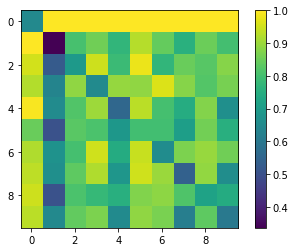

In [42]:
plt.imshow(train_data)
plt.colorbar()

## Test

In [43]:
mnist_test_data_sample = mnist_test_data[:]
mnist_test_labels_sample = mnist_test_labels[:]

In [44]:
mnist_test_data_sample[mnist_test_data_sample > threshold] = 1
mnist_test_data_sample[mnist_test_data_sample <= threshold] = -1

In [45]:
test_data = np.zeros((mnist_test_data_sample.shape[0],10))

for i in range(mnist_test_data_sample.shape[0]):
  for j in range(10):
    test_data[i][j] = dist.dissim(mnist_test_data_sample[i], moyenne[j])
    
test_data = np.divide(test_data.T, np.max(test_data, axis=1)).T

### Matrice carrée

In [46]:
matrice_carree = dist.dissim_mat(train_data)

### Matrice rectangle

In [47]:
matrice_rectangle = dist.dissim_mat(test_data, train_data)

## Isomap

In [50]:
import plotly.express as px

isomap = Isomap(n_components=3, n_neighbors=5, metric='precomputed')
isomap_training = isomap.fit_transform(matrice_carree)
isomap_test = isomap.transform(matrice_rectangle)

fig = px.scatter_3d(x=isomap_test[:,0], y=isomap_test[:,1], z=isomap_test[:,2], color=mnist_test_labels_sample)
fig.update_traces(marker_size = 1.5)

## PCoA

In [51]:
pcoa = KernelPCA(n_components=3, kernel='precomputed')
pcoa_train = pcoa.fit_transform(-.5*matrice_carree**2)
pcoa_test = pcoa.transform(-.5*matrice_rectangle**2)

fig = px.scatter_3d(x=pcoa_test[:,0], y=pcoa_test[:,1], z=pcoa_test[:,2], color=mnist_test_labels_sample)
fig.update_traces(marker_size = 1.5)

## K-médoïde

La v mesure est de : 0.246
La précision est de : 0.293


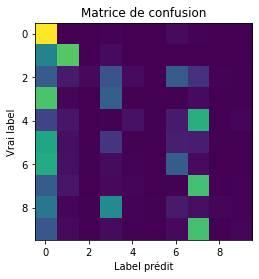

In [52]:
kmedoids_instance = kmedoids(matrice_carree, np.arange(10), data_type='distance_matrix')
kmedoids_instance.process()

kmedoids_train = kmedoids_instance.predict(matrice_carree)
kmedoids_test = kmedoids_instance.predict(matrice_rectangle)

print("La v mesure est de : %.3f" % (v_measure_score(mnist_test_labels_sample, kmedoids_test)))
print("La précision est de : %.3f" % (accuracy_score(mnist_test_labels_sample, kmedoids_test)))

conf_mat = np.zeros((10,10))
for i in range(kmedoids_test.shape[0]):
    conf_mat[mnist_test_labels_sample[i]][kmedoids_test[i]] += 1

plt.imshow(conf_mat)
plt.ylabel("Vrai label")
plt.xlabel("Label prédit")
plt.title("Matrice de confusion")
plt.show()

## KNN

## Partition binaire

In [53]:
def agglomerative_clustering_predict(agglomerative_clustering, dissimilarity_matrix):
    average_dissimilarity = list()
    for i in range(agglomerative_clustering.n_clusters):
        ith_clusters_dissimilarity = dissimilarity_matrix[:, np.where(agglomerative_clustering.labels_==i)[0]]
        average_dissimilarity.append(ith_clusters_dissimilarity.mean(axis=1))
    return np.argmin(np.stack(average_dissimilarity), axis=0)

La v mesure est de : 0.452


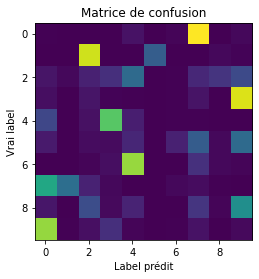

In [54]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=10, affinity='precomputed', linkage='average')
agglomerative_clustering.fit(matrice_carree)

agglo_train = agglomerative_clustering_predict(agglomerative_clustering, matrice_carree)
agglo_test = agglomerative_clustering_predict(agglomerative_clustering, matrice_rectangle)

print("La v mesure est de : %.3f" % (v_measure_score(mnist_test_labels_sample, agglo_test)))

conf_mat = np.zeros((10,10))
for i in range(agglo_test.shape[0]):
    conf_mat[mnist_test_labels_sample[i]][agglo_test[i]] += 1

plt.imshow(conf_mat)
plt.ylabel("Vrai label")
plt.xlabel("Label prédit")
plt.title("Matrice de confusion")
plt.show()